<a href="https://colab.research.google.com/github/Pedrohero13/hadoop/blob/main/tema1_2_analisis_grafico_informacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

In [ ]:
!java --version

openjdk 11.0.15 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [ ]:
!echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [ ]:
!echo $SPARK_HOME

/content/spark-2.4.8-bin-hadoop2.7


In [ ]:
import findspark
findspark.init()
from google.colab import files
from pyspark import SparkContext, SparkConf,SQLContext,HiveContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, lit
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
spark = SparkSession \
    .builder \
    .getOrCreate()

In [ ]:
spark.version

'2.4.8'

In [ ]:
sc = spark.sparkContext

In [ ]:
sc.version

'2.4.8'

In [ ]:
sqlContext = SQLContext(sc)

In [ ]:
sc.pythonVer

'3.7'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from math import sqrt
from pyspark.mllib.clustering import KMeans

In [ ]:
rdd = sc.parallelize(range(0,10))
rdd.take(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
rdd.takeSample(True,20,1)

[0, 6, 3, 4, 3, 1, 3, 7, 3, 5, 3, 0, 0, 9, 6, 5, 7, 9, 4, 7]

In [ ]:
rdd.takeSample(False,5,2)

[5, 9, 3, 4, 6]

In [ ]:
rdd.takeSample(False,15,3)

[1, 5, 6, 0, 9, 4, 7, 2, 8, 3]

In [ ]:
rdd.sample(False,0.5).take(5)

[0, 5, 8, 9]

In [ ]:
rdd.sample(False,0.5).take(5)

[1, 2, 3, 5, 6]

In [ ]:
df = spark.range(10)
df.show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



In [ ]:
df.sample(withReplacement=False,fraction=0.5,seed=1).show()

+---+
| id|
+---+
|  0|
|  2|
|  3|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



In [ ]:
df.sample(withReplacement=True,fraction=0.5,seed=1).show()

+---+
| id|
+---+
|  0|
|  2|
|  3|
|  4|
+---+



In [ ]:
df.sample(withReplacement=False,fraction=0.5,seed=2).show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  7|
+---+



In [ ]:
df.sample(withReplacement=False,fraction=0.5,seed=3).show()

+---+
| id|
+---+
|  0|
|  2|
|  9|
+---+



In [ ]:
path_csv="/content/daily_weather.csv"
df = sqlContext.read.csv(path_csv,header=True,inferSchema=True)
df.show(10)

+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
|number| air_pressure_9am|      air_temp_9am|avg_wind_direction_9am|avg_wind_speed_9am|max_wind_direction_9am|max_wind_speed_9am|rain_accumulation_9am|rain_duration_9am|relative_humidity_9am|relative_humidity_3pm|
+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
|     0|918.0600000000087| 74.82200000000041|                 271.1| 2.080354199999768|    295.39999999999986| 2.863283199999908|                  0.0|              0.0|    42.42000000000046|   36.160000000000494|
|     1|917.3476881177097| 71.40384263106537|    101.93517935618371|2.4430092157340217|    140.47154847112498|3.5333236016106238|               

In [ ]:
df_air_temp_9am=df.select("air_temp_9am")
df_air_temp_9am=df_air_temp_9am.na.drop()

In [ ]:
df_air_temp_9am=df_air_temp_9am.rdd.map(lambda row:row.air_temp_9am)
arr_air_temp_9am=df_air_temp_9am.collect()
df_air_temp_9am.take(10)

[74.82200000000041,
 71.40384263106537,
 60.637999999998776,
 70.13889486830053,
 44.29400000000284,
 78.40400000000422,
 70.04330431686239,
 51.710000000002346,
 80.58200000000384,
 47.4979999999998]

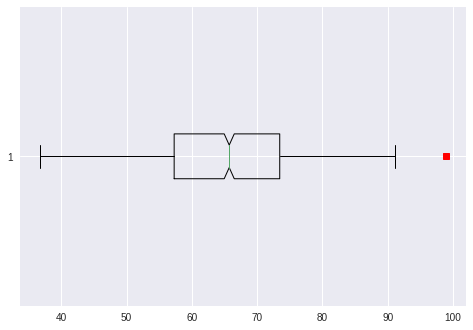

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(arr_air_temp_9am,1,"rs",0)
plt.show()

In [ ]:
import plotly.express as px
fig = px.histogram(x=arr_air_temp_9am,labels={'x':'air temp 9am','y':'Frecuencia'})
fig.show()

In [ ]:
df_nona=df.na.drop()
df_nona.createOrReplaceTempView("Weather")
query='SELECT relative_humidity_9am from Weather where air_temp_9am>65'
df_people_names = spark.sql(query)
df_people_names.show(10)

+---------------------+
|relative_humidity_9am|
+---------------------+
|    42.42000000000046|
|   24.328697291802207|
|   12.189101868764444|
|   35.130000000000265|
|   10.657421657822635|
|    29.58000000000045|
|   22.070000000000228|
|   15.189999999999962|
|   12.110889335294598|
|   21.031461768790646|
+---------------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import col
df_nona=df.na.drop()

df_nona=df_nona.withColumn("air_temp_by_rel_hum",col("air_temp_9am")>65)

df_grouped_rel_hum = df_nona.groupby("air_temp_by_rel_hum")
df_grouped_rel_hum.count().show()

+-------------------+-----+
|air_temp_by_rel_hum|count|
+-------------------+-----+
|               true|  558|
|              false|  506|
+-------------------+-----+



Text(0.5, 1.0, 'air humidity 9am')

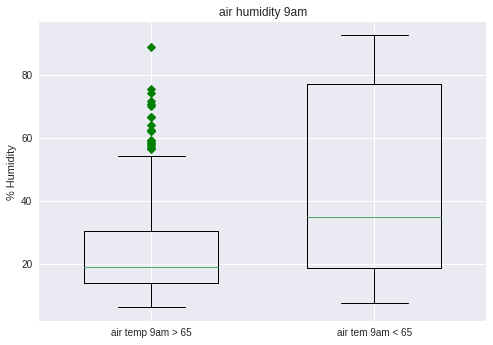

In [ ]:
df_gt_65=df_nona.filter(df_nona["air_temp_9am"]>65)
df_lt_65=df_nona.filter(df_nona["air_temp_9am"]<=65)

df_gt65_humidity=df_gt_65.select("relative_humidity_9am")
df_lt65_humidity=df_lt_65.select("relative_humidity_9am")

df_gt65_humidity=df_gt65_humidity.rdd.map(lambda row:row.relative_humidity_9am)
arr_gt65_humidity=df_gt65_humidity.collect()
df_lt65_humidity=df_lt65_humidity.rdd.map(lambda row:row.relative_humidity_9am)
arr_lt65_humidity=df_lt65_humidity.collect()

fig, ax = plt.subplots()
ax.boxplot(arr_gt65_humidity,0,"gD",positions=[1],widths=0.6)
ax.boxplot(arr_lt65_humidity,0,"bx",positions=[2],widths=0.6)

ax.set_xticklabels(['air temp 9am > 65','air tem 9am < 65'])
ax.set_ylabel('% Humidity')
ax.set_title('air humidity 9am')

In [ ]:
df_nona=df.na.drop()
df_temp_9am=df_nona.select("air_temp_9am")
df_humidity_9am=df_nona.select("relative_humidity_9am")
print(df_temp_9am.count(),df_humidity_9am.count())

1064 1064


In [ ]:
df_temp_9am=df_temp_9am.rdd.map(lambda row:row.air_temp_9am)
df_humidity_9am=df_humidity_9am.rdd.map(lambda row:row.relative_humidity_9am)
arr_temp_9am=df_temp_9am.collect()
arr_humidity_9am=df_humidity_9am.collect()

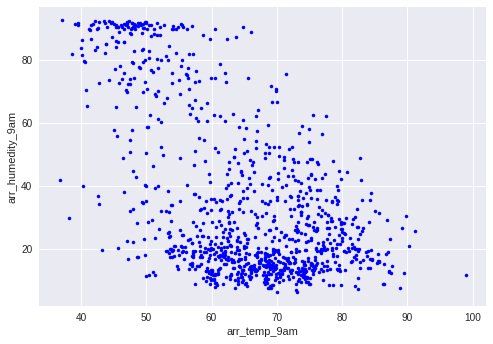

In [ ]:
plt.plot(arr_temp_9am,arr_humidity_9am,'b.')
plt.xlabel("arr_temp_9am")
plt.ylabel("arr_humedity_9am")
plt.show()

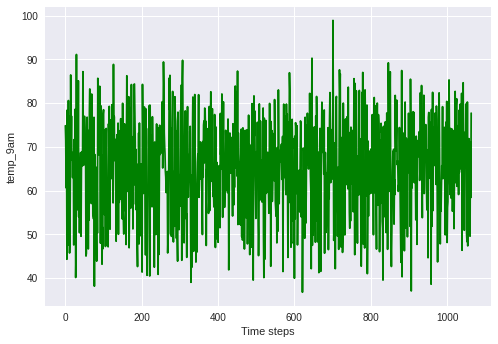

In [ ]:
plt.plot(arr_temp_9am,'g')
plt.xlabel("Time steps")
plt.ylabel("temp_9am")
plt.show()

In [ ]:
from matplotlib import markers
import plotly.express as px
fig=px.bar(x=arr_temp_9am)
fig.update_traces(marker_color='red',width=1.0)
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    yaxis=dict(
        title_text="air temp 9am",
        ticktext=["Time"],
        tickmode="array",
        titlefont=dict(size=30),
    )
)
fig.show()

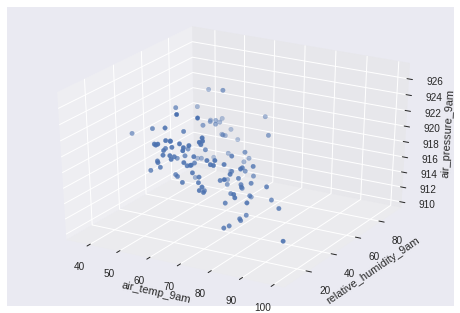

In [ ]:
df_nona=df.na.drop()
df_nona=df_nona.sample(False,0.1)
df_temp_9am=df_nona.select("air_temp_9am")
df_humidity_9am=df_nona.select("relative_humidity_9am")
df_pressure_9am=df_nona.select("air_pressure_9am")

df_temp_9am=df_temp_9am.rdd.map(lambda row:row.air_temp_9am)
df_humidity_9am=df_humidity_9am.rdd.map(lambda row:row.relative_humidity_9am)
df_pressure_9am=df_pressure_9am.rdd.map(lambda row:row.air_pressure_9am)
arr_temp_9am=df_temp_9am.collect()
arr_humidity_9am=df_humidity_9am.collect()
arr_pressure_9am=df_pressure_9am.collect()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.scatter(arr_temp_9am,arr_humidity_9am,arr_pressure_9am,marker='o')

ax.set_xlabel("air_temp_9am")
ax.set_ylabel("relative_humidity_9am")
ax.set_zlabel("air_pressure_9am")

plt.show()